## Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

### Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:
Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode

import scipy.stats as ss
from datetime import timedelta


%matplotlib inline
import seaborn as sns

sns.set(rc={'figure.figsize': (12, 6)}, style="whitegrid")

### Загрузим данные:

In [2]:
df_reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-igo-alekseev/shared/problem1-reg_data.csv', sep= ';')

In [3]:
df_auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-igo-alekseev/shared/problem1-auth_data.csv', sep= ';')

### Проведем EDA:

In [4]:
df_reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
df_reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [6]:
df_reg_data.describe()

,reg_ts,uid
count,1.000000e+06,1.000000e+06
mean,1.548332e+09,5.552354e+05
std,5.253653e+07,3.206011e+05
min,9.113822e+08,1.000000e+00
25%,1.528034e+09,2.776438e+05
50%,1.564454e+09,5.550455e+05
75%,1.585759e+09,8.329712e+05
max,1.600874e+09,1.110622e+06


In [7]:
df_reg_data.isna().value_counts()

reg_ts  uid  
False   False    1000000
dtype: int64

In [8]:
df_reg_data.uid.nunique()

1000000

In [9]:
df_reg_data.shape

(1000000, 2)

In [10]:
df_auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [11]:
df_auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [12]:
df_auth_data.describe()

,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


In [13]:
df_auth_data.isna().value_counts()

auth_ts  uid  
False    False    9601013
dtype: int64

In [14]:
df_auth_data.uid.nunique()

1000000

In [15]:
df_auth_data.shape

(9601013, 2)

In [16]:
df_auth_data.shape

(9601013, 2)

### Визуализируем данные:

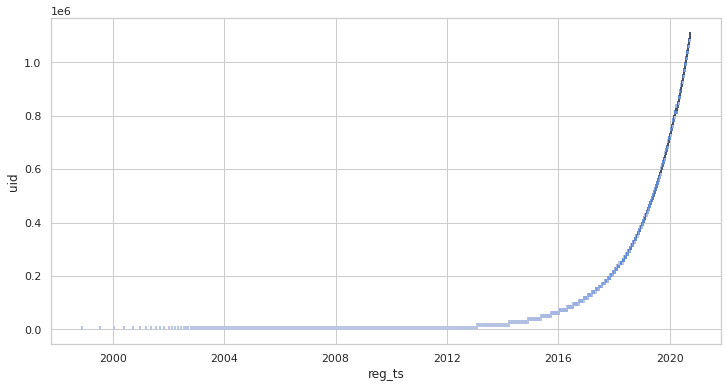

In [17]:
sns.histplot(x=pd.to_datetime(df_reg_data.reg_ts, unit='s'), y="uid", data=df_reg_data)

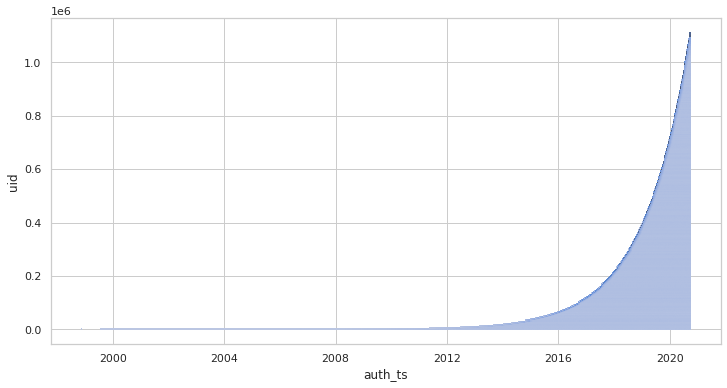

In [18]:
sns.histplot(x=pd.to_datetime(df_auth_data.auth_ts, unit='s'), y="uid", data=df_auth_data)

### Выводы по EDA:
- даты записываются в UNIX-формате, мы это учтем при написании функции;
- активность пользователей начала расти примерно с 14-15 года (функция с выбором интересующего периода);
- в данных нет пропусков;
- большой объем данных (мерджить можно не все, только интересующие)

### Напишем функцию расчет ретеншена:
Функция принимает 5 аргументов:
- df_1 - датасет, загруженный и сохраненный в переменную;
- df_2 - датасет, загруженный и сохраненный в переменную;
- start - начало интересующего периода в формате str;
- end - конец интересующего периода в формате str;
- how - D, W, M в формате str, означает метод формирования когорты (день/неделя/месяц).

На выходе функции имеем сводную таблицу, с расчитанным Retention Rate.


In [19]:
def retention(df_1, df_2, start, end, how):

    df_1["reg_ts"] = pd.to_datetime(df_1["reg_ts"], unit="s")  # меняем формат из unix
    df_2["auth_ts"] = pd.to_datetime(df_2["auth_ts"], unit="s")  # меняем формат из unix
    
    '''объединяем данные с учетом периода'''
    df = df_1.loc[(df_1.reg_ts > start) & (df_1.reg_ts < end)].merge(
        df_2, on="uid"
    )  
    
    '''определяем интересующий диапазон времени'''
    df_need = df.reset_index().drop(
        columns="index"
    ) 
    
    '''считаем период в днях'''
    df_need["period"] = (
        df_need["auth_ts"] - df_need["reg_ts"]
    ).dt.days  

    '''Далее конструкция определения когорты в зависимости от D, W, M'''
    if how == "D":
        df_need["reg_ts"] = df_need["reg_ts"].dt.date  # приводим когорту ко дню
    elif how == "W":
        df_need["reg_ts"] = (
            df_need["reg_ts"]
            .dt.to_period("W")
            .apply(lambda x: x.start_time)
            .dt.strftime("%Y-%m-%d")
        )  # приводим когорту к неделе
    elif how == "M":
        df_need["reg_ts"] = df_need["reg_ts"].dt.to_period(
            "M"
        )  # приводим когорту к месяцу

    '''Подготавливаем данные для расчета RR'''
    df_users = (
        df_need.groupby(["reg_ts", "period"])
        .agg({"uid": "nunique"})
        .reset_index()
        .rename(columns={"reg_ts": "cohort"})
    )
    
    '''Рассчитываем RR в долях'''
    cohort_names = list(df_users.cohort.unique())
    result = []
    for c in cohort_names:
        result.append(
            list(
                df_users.loc[df_users.cohort == c].uid
                / df_users.loc[df_users.cohort == c].uid.iloc[0]
            )
        )

    result_retention = result

    retention_percent = []
    for lst in result_retention:
        for value in lst:
            retention_percent.append(value)
    
    '''Добавляем RR таблицу'''
    df_users["retention"] = retention_percent  # 
    
    '''Определяем период'''
    nperiod = (
        pd.to_datetime(end) - pd.to_datetime(start)
    ).total_seconds() / 86400  

    '''Создаем сводную таблицу'''
    df_cohorts_pivot = df_users.query("period <= @nperiod & period != 0").pivot(
        index="cohort", columns="period", values="retention"
    )
    
    '''Создаем фрейм с размером когорты'''
    df_cohort_size = df_users \
        .groupby('cohort') \
        .agg({'uid': 'max'}) \
        .rename(columns={'uid': 'cohort_size'})
    
    df_cohort_size = list(df_cohort_size.cohort_size)
    
    '''Вставляем размер когорты в сводную таблицу'''
    df_cohorts_pivot.insert(loc= 0,
          column= 'cohort_size',
          value= df_cohort_size)
    
    '''Меняем стиль вывода данных'''
    ur_style = (
        df_cohorts_pivot.style.set_caption(
            "User retention by cohort"
        )  # добавляем подпись
        .background_gradient(cmap="twilight")  # раскрашиваем ячейки по столбцам
        .highlight_null("white")  # делаем белый фон для значений NaN
        .format(
            "{:.2%}", subset=[i for i in range(1, int(nperiod) + 1)], na_rep=""
        )  # числа форматируем как проценты, NaN заменяем на пустоту
    )
    return ur_style

retention(df_reg_data, df_auth_data, "2020-09-04", "2020-09-23", "D")


period,cohort_size,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cohort,,,,,,,,,,,,,,,,,,,,
2020-09-04,1593,3.83%,4.08%,4.14%,4.96%,7.41%,7.60%,3.89%,4.46%,4.83%,5.90%,5.08%,4.71%,5.27%,4.39%,4.27%,4.83%,4.39%,4.08%,0.82%
2020-09-05,1596,4.89%,4.01%,5.08%,5.33%,7.39%,6.83%,4.07%,5.33%,5.64%,5.76%,5.08%,3.95%,5.76%,4.70%,4.57%,5.20%,3.63%,0.88%,
2020-09-06,1599,4.94%,4.82%,5.50%,5.63%,6.07%,7.82%,5.07%,6.32%,4.82%,4.88%,5.00%,5.44%,5.19%,5.25%,4.63%,3.81%,1.06%,,
2020-09-07,1601,5.18%,4.37%,5.00%,6.31%,6.81%,6.56%,4.00%,5.00%,6.06%,6.00%,5.00%,4.87%,4.87%,4.00%,4.93%,1.31%,,,
2020-09-08,1604,3.93%,3.62%,4.61%,5.74%,7.73%,8.67%,4.49%,5.24%,5.49%,5.86%,6.42%,5.30%,4.99%,4.18%,1.12%,,,,
2020-09-09,1607,2.92%,4.11%,5.23%,6.60%,5.91%,6.66%,4.67%,4.17%,4.79%,4.04%,5.79%,3.86%,4.36%,0.81%,,,,,
2020-09-10,1609,4.29%,3.98%,4.85%,5.84%,6.65%,7.09%,5.28%,4.41%,5.34%,5.28%,5.22%,4.85%,0.99%,,,,,,
2020-09-11,1612,3.04%,4.34%,5.52%,5.58%,5.27%,8.50%,4.22%,4.28%,5.02%,5.71%,4.34%,1.49%,,,,,,,
2020-09-12,1614,3.53%,4.89%,4.21%,5.64%,5.95%,7.37%,4.21%,5.51%,5.45%,4.71%,0.68%,,,,,,,,


### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?


### Загрузим данные и разделим на тестовую и контрольную группы:

In [20]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
def df_reader(public_key_df):
    final_url_customers = base_url + urlencode(dict(public_key=public_key_df))
    return pd.read_csv(requests.get(final_url_customers).json()['href'], sep=';')

In [21]:
df_data = df_reader('https://disk.yandex.ru/d/SOkIsD5A8xlI7Q')

In [22]:
#df_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-igo-alekseev/Проект_1_Задание_2.csv', sep=';')

In [23]:
df_control_group = df_data.query('testgroup == "a"')

In [24]:
df_test_group = df_data.query('testgroup == "b"')

### Проведем EDA:

In [25]:
df_control_group.head()

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a


In [26]:
df_control_group.shape

(202103, 3)

In [27]:
df_control_group.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [28]:
df_control_group.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [29]:
df_control_group.nunique()

user_id      202103
revenue         269
testgroup         1
dtype: int64

In [30]:
df_control_group.revenue.value_counts()

0        200175
206          18
310          18
265          17
224          17
          ...  
37379         1
37341         1
37347         1
37407         1
37357         1
Name: revenue, Length: 269, dtype: int64

In [31]:
df_control_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202103 entries, 1 to 404768
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    202103 non-null  int64 
 1   revenue    202103 non-null  int64 
 2   testgroup  202103 non-null  object
dtypes: int64(2), object(1)
memory usage: 6.2+ MB


In [32]:
df_test_group.head()

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b


In [33]:
df_test_group.shape

(202667, 3)

In [34]:
df_test_group.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [35]:
df_test_group.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


In [36]:
df_test_group.revenue.value_counts()

0       200862
2003         6
3359         5
3367         4
3410         4
         ...  
3150         1
3022         1
2894         1
3535         1
2114         1
Name: revenue, Length: 1209, dtype: int64

In [37]:
df_test_group.nunique()

user_id      202667
revenue        1209
testgroup         1
dtype: int64

In [38]:
df_test_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202667 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    202667 non-null  int64 
 1   revenue    202667 non-null  int64 
 2   testgroup  202667 non-null  object
dtypes: int64(2), object(1)
memory usage: 6.2+ MB


### Визуализируем данные, но отфильтруем тех, кто не совершил покупку:

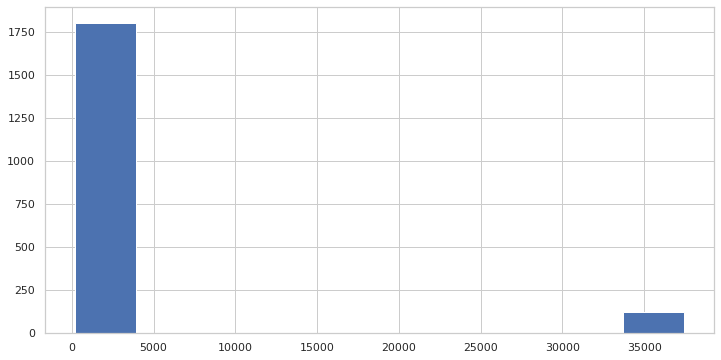

In [39]:
df_control_group.query('revenue > 0').revenue.hist()

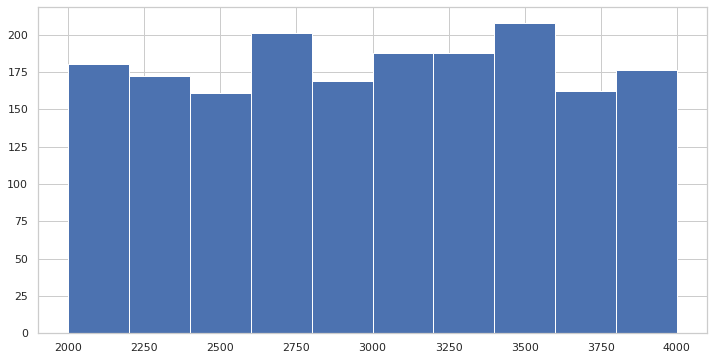

In [40]:
df_test_group.query('revenue > 0').revenue.hist()

### Выводы по EDA:
- в данных нет пропусков;
- объем данных большой, но очень много людей, которые не совершили покупку;
- распределния не соответсвтуют нормальным;
- все id пользователей уникальны;
- размах данных в группах сильно отличается, при этом среднее значение довольно близко.

### Проведем предварительные расчеты:

**Посчитаем конверсию (CR) для каждой группы:**

In [41]:
x, y = df_control_group.loc[df_control_group.revenue != 0].shape
x  # количество платящих пользователей

1928

In [42]:
CR_control = round((x / len(df_control_group)) * 100, 2)

In [43]:
CR_control 

0.95

In [44]:
z, i = df_test_group.loc[df_test_group.revenue != 0].shape
z  # количество платящих пользователей

1805

In [45]:
CR_test = round((z / len(df_test_group)) * 100, 2)

In [46]:
CR_test 

0.89

In [47]:
round(((CR_control - CR_test) * 100), 2) # Разница конверсий, %

6.0

**Посчитаем среднюю прибыль на привлеченного пользователя (ARPU) для каждой группы:**

In [48]:
ARPU_control = round(df_control_group.revenue.mean(), 2)  

In [49]:
ARPU_control

25.41

In [50]:
ARPU_test =  round(df_test_group.revenue.mean(), 2)  

In [51]:
ARPU_test

26.75

In [52]:
round((((df_test_group.revenue.mean() / df_control_group.revenue.mean()) - 1) * 100), 2)  # разница в ARPU, %

5.26

**Посчитаем среднюю прибыль на платящего пользователя (ARPPU) для каждой группы:**

In [53]:
ARPPU_control = round(df_control_group.query('revenue > 0').revenue.mean(), 2)

In [54]:
ARPPU_control

2664.0

In [55]:
ARPPU_test = round(df_test_group.query('revenue > 0').revenue.mean(), 2)  

In [56]:
ARPU_test

26.75

In [57]:
round((((df_test_group.query('revenue > 0').revenue.mean() / df_control_group.query('revenue > 0').revenue.mean()) - 1) * 100), 2)  
# разница в ARPPU, %

12.75

### Выводы по предварительным рассчетам:
- конверсия снизилась на 6%;
- ARPU увеличилась на 5,26%;
- ARPPU увеличилась на 12.75%.

### Выбор метрики для анализа

Исходя из обработки данных, представленных выше. Чтобы проверить алгоритмы подбора акционных предложений будем использовать метрики:
- **Ключевые метрики** - средний доход на одного пользователя (ARPU), средний доход на платящего пользователя (ARPPU)

Для исследования будем использовать распеределние **Revenue**. Сравнивать будем средние значения. Распределния не соответсвует нормальному, очень много неплатящих пользователей, но данных огромное количество и в этом случае будем использовать **T-тест** с параметром **equal_var = False**.
- **Дополнительная метрика** - Конверсия (CR)

Будем использовать критерий **Хи-квадрат**, введем категориальные переменные вида да/нет и проведем статистический тест этих переменных.


### Конверсия

подготовим данные для проведения статистического теста:

In [58]:
df_data['CR'] = df_data['revenue'].apply(lambda x: 'Да' if x > 0 else 'нет')  # добавим категориальные переменные

In [59]:
df_data.head()

,user_id,revenue,testgroup,CR
0,1,0,b,нет
1,2,0,a,нет
2,3,0,a,нет
3,4,0,b,нет
4,5,0,b,нет


In [60]:
for_hi = pd.crosstab(df_data.CR, df_data.testgroup)  # таблица для проведения теста 

In [61]:
for_hi

testgroup,a,b
CR,,
Да,1928,1805
нет,200175,200862


### Определим нулевую и альтернативную гипотезу:
- $H_0$: снижение конверсии не значимо статистически (взаимосвязи нет)
- $H_1$: снижение конверсии значимо (взамосвязь есть)

Проводим статистический тест **Хи-квадрат**:

In [62]:
stat, p_1, dof, expected = ss.chi2_contingency(for_hi)

In [63]:
print(f'P value = {round(p_1, 4)}')

P value = 0.0365


### Вывод по исследованию метрики - Конверсия:
После проведения теста получаем **P value < 0,05**. Мы имеем основания отклонить нулевую гипотезу и принять альтернативную. Приходим к выводу, что снижение конверсии на 6% имеет статистическую значимость.

### Cредний доход на одного пользователя (ARPU):

### Определим нулевую и альтернативную гипотезу:
- $H_0$: увеличение показателя ARPU не значимо статистически (взаимосвязи нет)
- $H_1$: увеличение показателя ARPU значимо (взамосвязь есть)

Проводим **T-тест**:

In [64]:
s, p_2 = ss.ttest_ind(df_control_group.revenue, df_test_group.revenue, equal_var=False)

In [65]:
print(f'P value = {round(p_2, 2)}')

P value = 0.53


### Вывод по исследованию метрики -  ARPU:
После проведения теста получаем **P value > 0,05**. Не имеем оснований отклонить нулевую гипотезу и принять альтернативную. Приходим к выводу, что увеличение показателя ARPU на 5,26% не имеет статистической значимости.

### Cредний доход на платящего пользователя (ARPPU):

### Определим нулевую и альтернативную гипотезу:
- $H_0$: увеличение показателя ARPPU не значимо статистически (взаимосвязи нет)
- $H_1$: увеличение показателя ARPPU значимо (взамосвязь есть)

Проводим **T-тест**:

In [66]:
s, p_3 = ss.ttest_ind(df_control_group.query('revenue > 0').revenue, 
                      df_test_group.query('revenue > 0').revenue, equal_var=False)

In [67]:
print(f'P value = {round(p_3, 2)}')

P value = 0.1


### Вывод по исследованию метрики -  ARPPU:
После проведения теста получаем **P value > 0,05**. Не имеем оснований отклонить нулевую гипотезу и принять альтернативную. Приходим к выводу, что увеличение показателя ARPPU на 12.75% не имеет статистической значимости.

### Общий вывод по заданию 2:

После проведения анализа данных и исследования статистической значимости выбранных метрик можно сделать следующие заключения:
- конверсия статистически значимо уменьшилась на 6%;
- увеличение позателя ARPU на 5.26% статистически не значимо.
- увеличение позателя ARPPU на 12.75% статистически не значимо.

Отвечая на поставленный вопрос о том, какой набор предложений можно считать лучшим, стоит принять во внимание один очень важный момент. При проведении А/B тестирования в контрольную группу попали пользователи, которые потратили сильно больше денег, чем остальные. Это оказало сильное повлияние на среднее значение дохода в данной группе. Различие средних значений по Т-тесту не показало статистически значимых отличий. Осмелюсь предположить, что если бы пользователи с высокими значениями **Revenue** отсутствовали, различия были бы значимы. Поэтому по результатам этого конкретного тестирования выбирать лучший набор предложений, с точки зрения ключевых метрик - **ARPU**/**ARPPU**, <u>**не стоит**</u>.
С точки зрения **конверсии (CR)** лучшим выбором является первый вариант акционных предложений, в контрольной группе.


**Считаю необходимым провести аналогичный A/B тест. Затем повторить анализ данных и исследовать статистическую значимость.**

### Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

 

### Базовые метрики:
С помощью этих метрик мы можем оценить эффетивность продукта.
- **LTV**

Отражение общей суммы денег, которую пользователь тратит во время текущего события в игре. Эту метрику важно рассматривать в сравнении CPI, потому что зарабатывать на своих пользователях нужно больше, чем тратить на их привлечение.

- **CPI**

Через CPI можно определить эффективность события в игре. Если на графике появился резкий подъем, то это означает, что тематическое событие имеет успех.

- **ARPU/ARPPU**

Соотношение ARPPU и ARPU показывает отношение платящих пользователей к ценовой политике и качеству события. 
 
 - **Average Session Duration**
 
С помощью этой метрики можно оценить продолжительность сессии пользователей в тематическом событии.

- **Installs**

Количество установок приложения. Побуждение людей устанавливать приложение во время события.

- **CR** 

Конверсия в покупку, отследить как влияет событие на целевое действие пользователя.
### Дополнительные метрики:
Эти метрики помогут оценить поведение пользователей во время события.
- **Stickiness rate**

Регулярность использования приложения в течение события. Отражает "залипательность", чем чаще заходят в игру, тем лучше действие события.

- **Retention rate**

Определим, возвращаются ли пользователи в игру при проведение тематического события.

### Метрики при усложненной механике:
Усложнение механик игры может привести к большому оттоку пользователей, так как в наше время люди больше отдают предпочтение "простым" играм, где можно расслабиться, повеселиться. В этом случае можно использовать метрики указанные выше. За исключением Retention rate, ее я бы заменил на Churn rate.

- **Churn rate**

Оценка оттока пользователей. Усложнение механики игры - это риск потерять пользователя из-за выросшей сложности.